In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [17]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False, save_record = True):
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
    
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    print([dim, sigma, rate])
    print(f"Data shape: {proc_data.shape}")

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, proc_err, num_iteration = iteration, use_epochs = True)

    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    z_std_gal = np.array([])

    labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), 
                                                                                                  np.expand_dims(info_data["z_true"].values, axis = 1), 
                                                                                                  np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = means[1]
        z_std_gal = np.concatenate((z_std_gal, np.tile(np.array(stds[1] / (means[1] + 1)), properties.shape[0])))


    print(np.sum(density_map))
    print(f"Topological error: {som.topographic_error(proc_data)}")
    print(f"Quantization error: {som.quantization_error(proc_data)}")
    print(f"Average redshift std: {np.nanmean(z_std_gal)}")

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (30, 20))
    plt.title(f"Mean z std: {round(np.nanmean(z_std_gal), 3)}")
    
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    plt.subplots_adjust(hspace = 0.07, wspace = 0)
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/6th_exploration/diagram/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if save_record:
    
        map_record = {}
        map_record["dim"] = dim
        map_record["sigma"] = sigma
        map_record["rate"] = rate
        map_record["band_cut"] = len(proc_data[0])
        map_record["mag_cut"] = len(proc_data)
        map_record["preproc"] = preproc
        map_record["som"] = som
        map_record["topo_err"] = som.topographic_error(proc_data)
        map_record["quan_err"] = som.quantization_error(proc_data)
        map_record["type"] = data_type
        map_record["distance"] = distance
        map_record["iter"] = iteration
        map_record["b_scale"] = b_scale
        map_record["prop_map"] = labels_map
        map_record["z_std_gal"] = z_std_gal
        map_record["mean_z_std"] = np.nanmean(z_std_gal)

        
        try:
            with open(f"D:/SPHEREx_SOM/record/6th_exploration/SOM/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.pkl",'wb') as handle:
                pickle.dump(map_record, handle, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    
    return som

In [31]:
def grid_points(x_cen, y_cen, x_range, y_range, x_step, y_step):
    x = np.arange(x_cen - x_range, x_cen + x_range + x_step, x_step)
    y = np.arange(y_cen - y_range, y_cen + y_range + y_step, y_step)
    xv, yv = np.meshgrid(x, y)
    return np.concatenate((xv.reshape(-1, 1),yv.reshape(-1, 1)), axis = -1)

In [32]:
data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
err = np.tile(data_all[0, 1::2],  (data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22896\2134533818.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]


In [ ]:
for i in range(1, 21):
    som = basic_som(data = data, data_type = "chi2_lup_shallow", err = err, info_data = info, dim = 70, preproc = "default", iteration = 3, sigma = 1.7, rate = i / 20, b_scale  = 100, save = True, distance = "chi2_distance")

In [ ]:
for i in grid_points(x_cen = 0.767, y_cen = 1.7, x_range = 0.2, y_range = 0.2, x_step = 0.05, y_step = 0.025):
    som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 70, preproc = "default", iteration = 6, sigma = i[1], rate = i[0], b_scale  = 10, save = True, distance = "chi2_distance")

In [ ]:
for i in range(2, 11):
    som = basic_som(data = data, data_type = "chi2_lup_shallow", err = err, info_data = info, dim = 70, preproc = "default", iteration = i, sigma = 2.6, rate = 0.25, b_scale  = 1000, save = True, distance = "chi2_distance")

In [ ]:
for i in [0.01, 0.1, 1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6]:
    som = basic_som(data = data, data_type = "chi2_lup_deep", err = err, info_data = info, dim = 70, preproc = "default", iteration = 3, sigma = 1.3, rate = 0.2, b_scale  = i, save = True, distance = "chi2_distance")

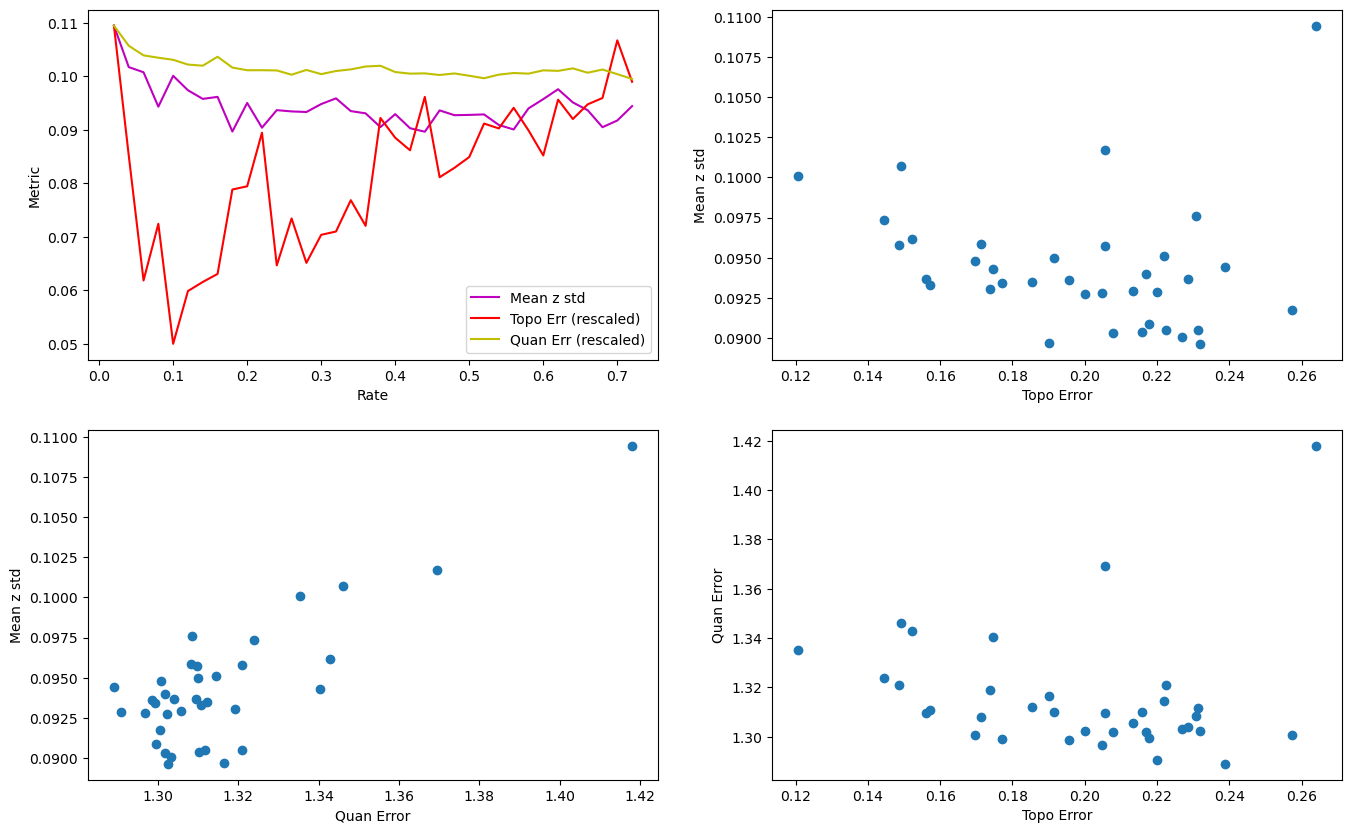

In [42]:
a = os.listdir("D:/SPHEREx_SOM/record/6th_exploration/SOM/")

d = []


for i in a:
    c = []
    if "deep_70_2.1" in i and "3_100.pkl" in i:
        with open("D:/SPHEREx_SOM/record/6th_exploration/SOM/" + i, "rb") as fh:
            b = pickle.load(fh)
        c.append(b["rate"])
        c.append(b["mean_z_std"])
        c.append(b["topo_err"])
        c.append(b["quan_err"])
        d.append(c)

def rate_sort(r):
    return r[0]

d.sort(key = rate_sort)
d = np.array(d)


plt.close()
plt.figure(figsize = (10 * 1.618, 10))

plt.subplot(221)
plt.plot(d[:, 0], d[:, 1] / (np.max(d[:, 1]) / np.max(d[:, 1])), label = "Mean z std", c = "m")
plt.plot(d[:, 0], d[:, 2] / (np.max(d[:, 2]) / np.max(d[:, 1])), label = "Topo Err (rescaled)", c = "r")
plt.plot(d[:, 0], d[:, 3] / (np.max(d[:, 3]) / np.max(d[:, 1])), label = "Quan Err (rescaled)", c = "y")
plt.legend()
plt.xlabel("Rate")
plt.ylabel("Metric")

plt.subplot(222)
plt.scatter(d[:, 2], d[:, 1])
plt.ylabel("Mean z std")
plt.xlabel("Topo Error")

plt.subplot(223)
plt.scatter(d[:, 3], d[:, 1])
plt.ylabel("Mean z std")
plt.xlabel("Quan Error")

plt.subplot(224)
plt.scatter(d[:, 2], d[:, 3])
plt.ylabel("Quan Error")
plt.xlabel("Topo Error")

plt.show()